In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import scipy
import pickle

In [2]:
sys.path.append('../../source/')
sys.path.append('../Tang/')
from JungeUtilities import beta_hedging, portfolio_ize, date_to_int
from get_beta import get_beta
from energy_functions import correlation, sharpe, volatility
from Hedge import Hedge

In [3]:
hedge =Hedge(begindate='2007-01-01', enddate='2007-12-31')

In [31]:
np.random.binomial(1,0.5)

0

In [40]:
def swap(market_symbols, year_symbols):
    """
    Randomly changes the symbols in a market. Can either grow or shrink the market by 1 asset.  
    
    Inputs:
    -------
    market_symbols: list of symbols that are in a market
    year_symbols:   list of all the possible symbols for a given year
    
    Output:
    -------
    symbols: list of symbols in the market after the random change.  
    
    """
    coin_flip = np.random.binomial(1, 0.5)
    
    if (coin_flip == 0) and len(market_symbols)>10: # Shrink the market by one asset
        
        # Pick a random list index and pop that symbol off
        market_symbols.pop(np.random.randint(len(market_symbols)))
        return market_symbols
    
    else: # Grow the market by one asset
        
        # Get a list of the symbols for that year that are not already in the portfolio
        potential_symbols = list(set(year_symbols) - set(market_symbols))
        symbol_to_add = np.random.choice(potential_symbols)
        market_symbols.append(symbol_to_add)
        return market_symbols

In [37]:
hedge.generateRandomMarket(10)
hedge.generateRandomPort(20)
hedge.stockuniverse

Index([u'A', u'AA', u'AAL', u'AAME', u'AAN', u'AAON', u'AAP', u'AAPL', u'AAU',
       u'AAV',
       ...
       u'ZBRA', u'ZEUS', u'ZF', u'ZHNE', u'ZIOP', u'ZIXI', u'ZN', u'ZNH',
       u'ZTR', u'ZUMZ'],
      dtype='object', length=3526)

In [48]:
def simulated_annealing(hedge, init_temp, min_temp, cool_by, reanneal, num_iter, energy_func):
    """
    Inputs:
    -------
    hedge: 
        hedge object that already has an instantiated market and portfolio. 
    init_temp: 
        float that controls the initial temperature of the algorithm
    min_temp: 
        float that acts as a floor for the decreasing temperature.  When this is hit, we heat back up to init_temp.  
    cool_by: 
        float that controls the speed that the cooling occurs
    reanneal: 
        integer that controls how many iterations pass between cooling steps
    num_iter: 
        integer that controls the total number of iterations that the algorithm runs
    energy_func:
        function that determines the energy state, eg correlation, volatility, sharpe ratio
    
    Returns:
    --------
    states: 
        a history of the current energy state at each iteration
    best_market: 
        list of the symbols for the best hedging market found
    """
    accepted=0
    
    hedge.generateRandomMarket()
    
    portfolio_values = hedge.dollar_portfolio_sum
    portfolio_returns = hedge.dollar_portfolio_sum_ret
    
    market = list(hedge.market)
    market_values = hedge.dollar_market_sum
    market_returns = hedge.dollar_market_sum_ret
    
    spy_returns = hedge.spy.pct_change()[61:]
    
    # Get betas from portfolio returns and market returns.
    _, betas = get_beta(portfolio_returns, market_returns)
    
    # Perform beta hedging.
    hedged_returns = beta_hedging(pd.Series(betas, index=market_values[60:].index),\
                                  market_values[60:], portfolio_values[60:])
    hedged_returns = hedged_returns.values.reshape(hedged_returns.shape[0])

        
    # A running account of the best market found.  This is updated as better markets are found.       
    best_market_energy = energy_func(hedged_returns[1:], spy_returns[1:])
    best_market = hedge.market
    
    # Initial value for old_E is the initial total value of the starting point.
    old_E = best_market_energy
    
    temperature = init_temp
    
    # A history of the current state of the algorithm.
    states = np.zeros(num_iter)
    
    for i in range(num_iter):
#         print len(market),
        if i%10==0:
            print i
        
        # Switch the bag up a little bit and recalculate market values and returns.  
        market = list(hedge.market)
        hedge.market = swap(market, hedge.stockuniverse)

#         print 'market', market
        
        market_values = hedge.dollar_market_sum
        market_returns = hedge.dollar_market_sum_ret
#         print hedge.dollar_market_sum_ret[:5]
            
        # Get beta values from portfolio and market.
        _, betas = get_beta(portfolio_returns, market_returns)
        
        # Perform beta hedging.
        hedged_returns = beta_hedging(pd.Series(betas, index=market_values[60:].index), \
                                          market_values[60:], portfolio_values[60:])
        hedged_returns = hedged_returns.values.reshape(hedged_returns.shape[0])

        # Examine energy state of the new bag.
        new_E = energy_func(hedged_returns[1:], spy_returns[1:])
        
        delta_E = new_E - old_E
        
        # We always accept an improvement.
        if new_E < old_E:
            accepted+=1
            #market = proposed_market
            states[i] = new_E
            old_E = new_E
            # Update our running best bag found.
            if new_E > best_market_energy:
                best_market_energy = new_E
                best_market = market
        # We sometimes accept a decline because this can get us out of a local minimum.
        elif np.random.rand() < np.exp(-delta_E / temperature):
            #market = proposed_proposed
            states[i] = new_E
            old_E = new_E

        # And sometimes we just stay where we are until something better comes along.
        else: 
            states[i] = old_E
            # Put the old market back in
            hedge.market = market
            
        # Cool down slowly at the defined interval.
        if num_iter % reanneal == 0:
            temperature = temperature * cool_by
            
            # Reheat when the temperature gets too cold.
            if temperature < min_temp:
                temperature = init_temp
                
    return accepted, states, best_market

In [52]:
ac, st, bm = simulated_annealing(hedge, init_temp=1, min_temp=0.01, cool_by=0.99, reanneal=100, num_iter=100, \
                    energy_func=correlation)
print ac, "Accepted"

0
10
20
30
40
50
60
70
80
90
52 Accepted


In [53]:
len(hedge.market)

12

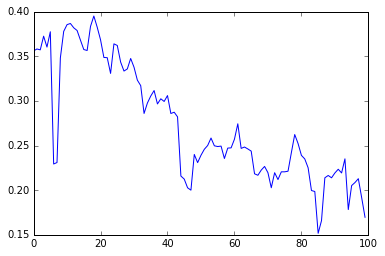

In [54]:
plt.plot(st)